In [93]:
import pandas as pd
import numpy as np
import scanpy as sc
import torch
from torch.distributions import Gamma

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [61]:
from utils import get_mean_normal, find_location_index_cell_type, metrics_vector, discrete_histogram
from scipy.stats import ks_2samp, ttest_ind
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import anndata

In [186]:
from scvi.model import DestVI, CondSCVI

In [4]:
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

In [7]:
path = "/home/ubuntu/simu_runs/run_B"

sc_adata = sc.read_h5ad(path+"/sc_simu.h5ad")
st_adata = sc.read_h5ad(path+"/st_simu.h5ad")
sc_adata.raw = sc_adata

In [6]:
# for one cell type, we would like to:
# 1. Find two spatial regions enriched in cell type A, but with very different latent variables within A
# 2. Do differential expression on the single-cell that we may extract from the grountruth
# 3. Do differential expression with DestVI from the spatial data
# 4. Compare everything

In [8]:
for i in range(5):
    st_adata.obs[f"Cell Type {i}"] = st_adata.obsm["cell_type"][:, i]

for i in range(4):
    st_adata.obs[f"Gamma {i}"] = st_adata.obsm["gamma"][:, i]
    st_adata.obs[f"Gene {i}"] = st_adata.X[:, i].A

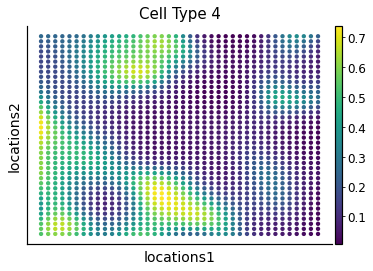

In [185]:
# choose a cool cell type
sc.pl.embedding(st_adata, basis="locations", color="Cell Type 4")

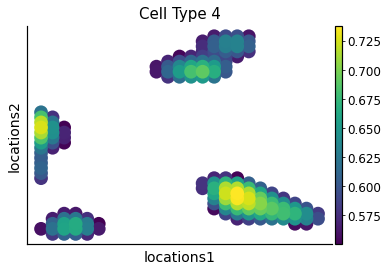

In [120]:
sc.pl.embedding(st_adata[st_adata.obs["Cell Type 4"] > 0.55], basis="locations", color="Cell Type 4")

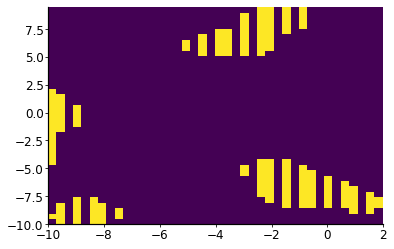

In [121]:
# get two modes for DE based on spatial coordinates (these will have different Gamma per design!)
subset = st_adata[st_adata.obs["Cell Type 4"] > 0.55].copy()
plt.hist2d(subset.obsm["locations"][:, 0], subset.obsm["locations"][:, 1], bins=40 )
plt.show()

In [122]:
# do the subsetting 
subset_A = np.logical_and(st_adata.obs["Cell Type 4"] > 0.55, st_adata.obsm["locations"][:, 1] > 3)
subset_B = np.logical_and(st_adata.obs["Cell Type 4"] > 0.55, st_adata.obsm["locations"][:, 1] < 3)
subset_B = np.logical_and(subset_B, st_adata.obsm["locations"][:, 0] > -5)

In [123]:
# extract the single-cell at those coordinates
_, rank = np.unique(sc_adata.obsm["locations"], return_inverse=True, axis=0)

sc_subset_A = np.concatenate([np.where(x == rank)[0] for x in np.where(subset_A)[0]])
sc_slice_A = sc_adata[sc_subset_A].copy()
sc_slice_A = sc_slice_A[sc_slice_A.obs["cell_type"] == 4].copy()

sc_subset_B = np.concatenate([np.where(x == rank)[0] for x in np.where(subset_B)[0]])
sc_slice_B = sc_adata[sc_subset_B].copy()
sc_slice_B = sc_slice_B[sc_slice_B.obs["cell_type"] == 4].copy()

In [124]:
sc.pp.normalize_total(sc_slice_A, target_sum=1e4)
sc.pp.log1p(sc_slice_A, base=2)

sc.pp.normalize_total(sc_slice_B, target_sum=1e4)
sc.pp.log1p(sc_slice_B, base=2)

In [125]:
# sc_de = np.array([ks_2samp(sc_slice_A.X.A[:, gene], 
#                        sc_slice_B.X.A[:, gene], 
#                        alternative='two-sided').pvalue for gene in range(sc_slice_A.n_vars)])
sc_de = np.array([ttest_ind(sc_slice_A.X.A[:, gene], 
                       sc_slice_B.X.A[:, gene], 
                       alternative='two-sided').pvalue for gene in range(sc_slice_A.n_vars)])
sc_lfc = sc_slice_A.X.A.mean(0) - sc_slice_B.X.A.mean(0)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


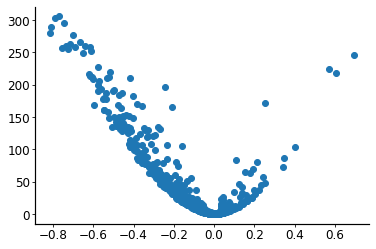

In [126]:
plt.scatter(sc_lfc, -np.log10(sc_de))

In [127]:
spatial_model = DestVI.load(path+"/destvi_latent", st_adata)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'ind_x']                                                                            
INFO     Successfully registered anndata object containing 1600 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [128]:
imp_A = spatial_model.get_scale_for_ct(4,indices=subset_A).values
imp_B = spatial_model.get_scale_for_ct(4,indices=subset_B).values

In [152]:
# get statistics
avg_library_size = np.mean(np.sum(st_adata.X, axis=1).A.flatten())
exp_px_o = spatial_model.module.px_o.detach().exp().cpu().numpy()
mean_A = avg_library_size * imp_A
mean_B = avg_library_size * imp_B


# create distribution
concentration_A = torch.tensor(avg_library_size * imp_A / exp_px_o)
concentration_B = torch.tensor(avg_library_size * imp_B / exp_px_o)
rate = torch.tensor(1. / exp_px_o)

# generate
N = 1
simulated_case = Gamma(concentration=concentration_A, rate = rate).sample((N,)).cpu().numpy()
simulated_case = np.log(simulated_case + 1)
simulated_case = simulated_case.reshape((-1, simulated_case.shape[-1]))

simulated_control = Gamma(concentration=concentration_B, rate = rate).sample((N,)).cpu().numpy()
simulated_control = np.log(simulated_control + 1)
simulated_control = simulated_control.reshape((-1, simulated_control.shape[-1]))

In [161]:
de = np.array([ttest_ind(simulated_case[:, gene], 
                   simulated_control[:, gene], 
                   alternative='two-sided').pvalue for gene in range(simulated_control.shape[1])])

In [180]:
lfc = np.log2(1 + mean_A).mean(0) - np.log2(1 + mean_B).mean(0)
# lfc = np.log2(mean_A.mean(0)) - np.log2(mean_B.mean(0))

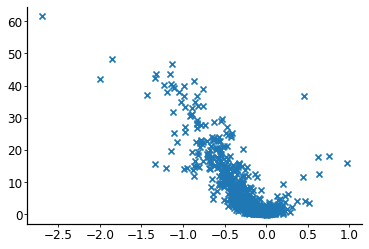

In [181]:
plt.scatter(lfc, -np.log10(de), marker="x")

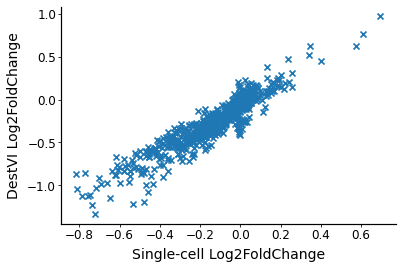

In [200]:
gene_mask = np.logical_and(de != 0, sc_de != 0)
plt.scatter(sc_lfc[gene_mask], lfc[gene_mask], marker="x")
# plt.plot(np.linspace(-1, 1, 40), np.linspace(-1, 1, 40), c="red")
plt.xlabel("Single-cell Log2FoldChange")
plt.ylabel("DestVI Log2FoldChange")
# cbar = plt.colorbar()
# cbar.set_label("DestVI -log10 p-value")
plt.show()

In [177]:
pearsonr(sc_lfc[gene_mask], lfc[gene_mask])

(0.9426725574876662, 0.0)

### Now look at fit for a gene that does not depend on other genes

In [203]:
import scipy.sparse as sp
import scvi

In [350]:
# flip three gene at random
sc_adata = sc.read_h5ad(path+"/sc_simu.h5ad")
index_genes = [9, -2, -1]
dense_matrix = sc_adata.X.A
for index_gene in index_genes:
    dense_matrix[:, index_gene] = np.random.permutation(dense_matrix[:, index_gene])
sc_adata.X = sp.csr_matrix(dense_matrix)

In [351]:
scvi.data.setup_anndata(sc_adata, labels_key="cell_type")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 32000 cells, 2000 vars, 1 batches,
         5 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [352]:
sc_model = CondSCVI(sc_adata)
sc_model.train(max_epochs=20)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it, loss=2.29e+03, v_num=1]


In [358]:
px_r = torch.exp(sc_model.module.px_r).cpu().detach().numpy()
x_hat = px_r * sc_model.get_normalized_expression().values
x_star = sc_adata.X.A
x_hat = x_hat

In [359]:
def np_pearson_cor(x, y):
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)
def spearman(x, y):
    a = []
    for i in range(x.shape[1]):
        a.append(spearmanr(x[:, i], y[:, i]).correlation)
    return np.array(a)

In [360]:
from scipy.stats import spearmanr

In [361]:
data = np.diag(np_pearson_cor(x_star, x_hat))
# data = spearman(x_star, x_hat)

In [362]:
index_genes

[9, -2, -1]

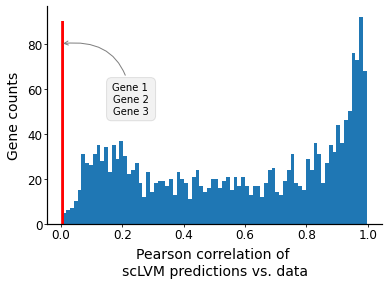

In [378]:
plt.hist(data, bins=80)
plt.vlines(data[index_genes], 0, 90, color="red")
plt.annotate("Gene 1 \nGene 2\nGene 3", xy=[0, 80], xytext=(+70,-70),
ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.xlabel("Pearson correlation of \nscLVM predictions vs. data")
plt.ylabel("Gene counts")
plt.show()

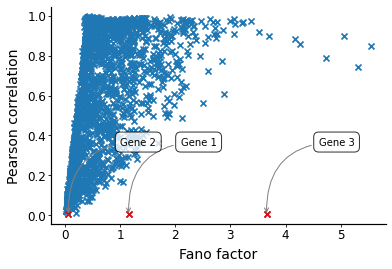

In [386]:
xstamp = x_star.mean(0)/x_star.std(0)
plt.annotate("Gene 1", xy=[xstamp[9], 0], xytext=(+70,70),
ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.annotate("Gene 2", xy=[xstamp[-1], 0], xytext=(+70,70),
ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.annotate("Gene 3", xy=[xstamp[-2], 0], xytext=(+70,70),
ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.scatter(xstamp, data, marker="x")
plt.scatter(xstamp[index_genes], data[index_genes], c="red", marker="x")
plt.xlabel("Fano factor")
plt.ylabel("Pearson correlation")
plt.show()

In [197]:
sc_adata.X

<32000x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 25946608 stored elements in Compressed Sparse Row format>

In [ ]:
np.random.shuffle()